In [191]:
import skimage
import skimage.transform
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import os
from PIL import Image

# %% Focales y píxeles   
f_th = 5.6# mm
f_rgb = 3 #1.88 # mm 1.93mm, 1.88mm
     
Ps_rgb = 9.5 #1.34 # micras
Ps_th = 12 # micras

In [192]:
x_foc = f_rgb/f_th
x_pix = Ps_th/Ps_rgb
# Correcciones vertical y horizontal por desplazamiento de los ejes ópticos en la montura
Cv = 2
Ch = 46
print('x_foc = ', x_foc)
print('x_pix = ', x_pix)

x_foc =  0.5357142857142857
x_pix =  1.263157894736842


In [193]:
# termicas = glob.glob("/media/quizhpilema.134643/Datos1/Phenomenal_robotics/fotos_ablitas/20190711_132654_R.jpg")
# visibles = glob.glob("/media/quizhpilema.134643/Datos1/Phenomenal_robotics/fotos_ablitas/AMBA0331.JPG")

termicas = glob.glob("raw/thermal_image_20240417_153857.tiff")
visibles = glob.glob("raw/infra1_image_20240417_153857.jpg")

paired_images = list(zip(visibles, termicas))
# print(paired_images)

(-0.5, 639.5, 359.5, -0.5)

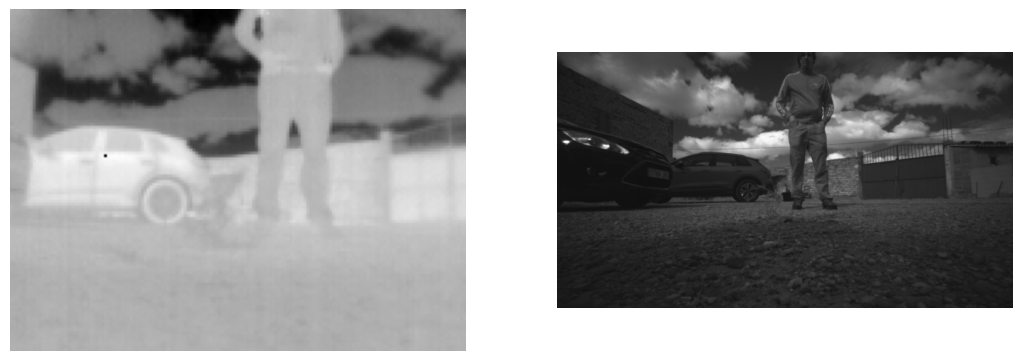

In [194]:
th = io.imread(termicas[0])
# Valores mínimos y máximos conocidos
min_val = th.min()
max_val = th.max()

# Estandarizar la imagen
standardized_img = (th - min_val) / (max_val - min_val)

# Escalar al rango 0-65535
scaled_img = (standardized_img * 256).astype(np.uint8)

# # Convertir de nuevo a una imagen usando Pillow
# final_img = Image.fromarray(scaled_img)

# th = io.imread(scaled_img)
# thermal with 3 channels
th = np.stack((scaled_img,)*3, axis=-1)
plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.imshow(th);
plt.axis('off')
        
# %% IMAGEN VISIBLE
rgb = io.imread(visibles[0])   
rgb = np.stack((rgb,)*3, axis=-1)
plt.subplot(132)
plt.imshow(rgb);
plt.axis('off')

In [195]:
# %% COBERTURA SENSOR TERMICO sobre senor RGB
size_th = th.shape[0:2] # pixeles termicos
rgb_th = rgb.shape[0:2] # pixeles rgb
sizeTh_rgb = np.floor(np.float32(rgb_th) * x_foc *x_pix)
print(np.float32(rgb_th))
print(size_th, sizeTh_rgb)
print(rgb_th)

[360. 640.]
(120, 160) [243. 433.]
(360, 640)


2.025
(243, 324, 3)


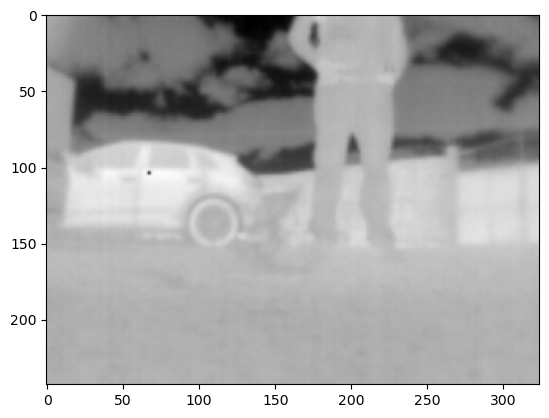

In [196]:
# %% IMAGEN TÉRMICA ESCALADA
scale = sizeTh_rgb[0]/th.shape[0]
print(scale)
th_sc = skimage.transform.rescale(th, scale,multichannel=True)
print(th_sc.shape)
plt.imshow(th_sc)

In [197]:
# %% limites de intervalos pixeles
rgb_center = np.float32(rgb.shape[0:2])/2.
print(rgb_center)
# indice del pixel central
rgb_center = [round(rgb_center[0]),round(rgb_center[1])]
print(rgb_center)
print(sizeTh_rgb[0])
print(sizeTh_rgb[0] % 2)

Dh = math.floor(sizeTh_rgb[0] / 2) 
botpixfil = rgb_center[0]-(Dh+1) 

print(Dh)
print(botpixfil)


[180. 320.]
[180, 320]
243.0
1.0
121
58


In [198]:
# límites en coords pixel de la ventana térmica sobre la RGB
if sizeTh_rgb[0] % 2 == 0:
    Dh = sizeTh_rgb[0] / 2 
    print("=0 en 0")
    print(Dh)
    botpixfil = rgb_center[0]-Dh
    print(botpixfil)
elif sizeTh_rgb[0] % 2 != 0:
    Dh = math.floor(sizeTh_rgb[0] / 2) 
    print(Dh)
    botpixfil = rgb_center[0]-(Dh+1)    
    print(botpixfil)
        
if sizeTh_rgb[1] % 2 == 0:
    print("=0 en 1")
    Dw = np.floor(sizeTh_rgb[1] / 2) 
    print(Dw)
    leftpixcol = rgb_center[1]-Dw
    print(leftpixcol)
elif sizeTh_rgb[1] % 2 != 0:
    Dw = math.floor(sizeTh_rgb[1] / 2) 
    print(Dw)
    leftpixcol = rgb_center[1]-(Dw+1)
    print(leftpixcol)

121
58
216
103


In [199]:
# Correcciones horizontal y vertical
        # Tienen en cuenta el desplazamiento en vertical y horizontal de los
        # ejes ópticos de las cámaras. Las unidades son píxels de la RGB
        # dividir entre 1.34 micras para pasar a uds absolutas.
        
botpixfil -= Cv
leftpixcol += Ch 
        #
        # %% SUPERPOSICION IMAGENES
rgb_th=skimage.img_as_float(rgb.copy())
rgb_th[int(botpixfil):int(botpixfil)+th_sc.shape[0],int(leftpixcol):int(leftpixcol)+th_sc.shape[1]]=th_sc


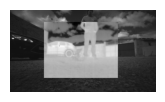

In [200]:
plt.subplot(133)
plt.imshow(rgb_th)
plt.axis('off')
plt.show()    

In [201]:
# %% Grabar imagen visible-termica superpuesta
        # nombre termica
headth, tailth = os.path.split(termicas[0])
id = tailth.find(".")
tailth = tailth[0:id]
headrgb, tailrgb = os.path.split(visibles[0])
filename = ["./prueba/"+ tailth + tailrgb]
print(filename[0])
io.imsave(filename[0], skimage.img_as_ubyte(rgb_th))

./prueba/thermal_image_20240417_153857infra1_image_20240417_153857.jpg


In [202]:
# !pip install imutils
